In [1]:
import numpy as np
import scipy.sparse as sp
import sknetwork as sn
#import abcd_graph
import matplotlib.pyplot as plt
from tqdm import tqdm

import os

from fstar import *

import matplotlib.gridspec as gridspec
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
def hex2rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3))

In [4]:
# Function to handle building ABCD+oo graphs with the julia library
# Requires julia to be installed and ABCDGraphGenerator.jl to be added.

abcd_path = "~/Research/ABCDGraphGenerator.jl/utils/"
this_path = "~/Research/Fstar/experiments/"
julia = "julia "


def _run_julia_abcd(
    n,
    xi,
    nout=0,
    rng=None,
    gamma=2.5,
    delta=5,
    Delta=None,
    s=25,
    S=None,
    beta=1.5,
    d=8,
    rho=0.0,
):
    if rng is None:
        rng = np.random.default_rng()
    rdm = str(rng.choice(100000))
    if Delta is None:
        Delta = int(n**0.5)
    if S is None:
        S = int(n**0.767)
    # if nout <= 0:
    #     raise ValueError("Cannot parse without outliers")

    config = f"""seed = "{rdm}"                   # RNG seed, use "" for no seeding
n = "{n}"                   # number of vertices in graph
nout = "{nout}"                  # number of vertices in graph that are outliers
t1 = "{gamma}"                      # power-law exponent for degree distribution
d_min = "{delta}"                   # minimum degree
d_max = "{Delta}"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "{beta}"                      # power-law exponent for cluster size distribution
c_min = "{s}"                  # minimum cluster size after growing
c_max = "{S}"                # maximum cluster size after growing
c_max_iter = "1000"           # maximum number of iterations for sampling cluster sizes
xi = "{xi}"                    # fraction of edges to fall in background graph
islocal = "false"             # if "true" mixing parameter is restricted to local cluster, otherwise it is global
isCL = "false"                # if "false" use configuration model, if "true" use Chung-Lu
degreefile = "deg_{rdm}.dat"        # name of file do generate that contains vertex degrees
communitysizesfile = "cs_{rdm}.dat" # name of file do generate that contains community sizes
communityfile = "com_{rdm}.dat"     # name of file do generate that contains assignments of vertices to communities
networkfile = "edge_{rdm}.dat" """
    config_file = f"config_{rdm}.dat"
    with open(config_file, "w") as f:
        print(config, file=f)
    cmd = julia + abcd_path + "abcd_sampler.jl " + this_path + config_file
    os.system(cmd + " >/dev/null 2>&1")

    adjacency = sn.data.from_csv(f"edge_{rdm}.dat")
    adjacency = adjacency[1:][:, 1:]
    list_of_coms = []
    n_coms = 0
    with open(f"com_{rdm}.dat", "r") as file:
        for line in file:
            # each line has the format: node_id\t[a,b,c]\n
            # for this node belonging to communities a,b,c
            # if there are outliers then they have community [-1]
            # node_id counts up starting at 0
            x = line.split("\t")[1].rstrip()  # gets a,b,c
            x_coms = int(x)
            list_of_coms.append(x_coms)
            n_coms = max(n_coms, x_coms - 1)

    labels = sp.lil_matrix((adjacency.shape[0], n_coms), dtype="bool")
    for x, x_coms in enumerate(list_of_coms):
        if x_coms == 1:
            continue
        labels[x, x_coms - 2] = True
    labels = labels.transpose().tocsr()

    cmd = f"rm *_{rdm}.dat"
    os.system(cmd + " >/dev/null 2>&1")

    return adjacency, labels

In [9]:
XIS = np.linspace(0.2, 0.8, 15)
REPS = 10
n = 5000
nout = 0

fine = sn.clustering.Louvain(resolution=4.5, n_aggregations=3, tol_optimization = 0.01, random_state=42)
med = sn.clustering.Louvain(resolution=1.25, n_aggregations=3, tol_optimization = 0.01, random_state=42)
coarse = sn.clustering.Louvain(resolution=0.67, n_aggregations=3, tol_optimization = 0.01, random_state=42)

similarity = np.empty((3, len(XIS), REPS))
ga_similarity = np.empty_like(similarity)
num = np.empty((4, len(XIS), REPS), dtype="int64")
rng = np.random.default_rng(seed=41)

with tqdm(total = len(XIS) * REPS) as pbar:
    for i, xi in enumerate(XIS):
        for j in range(REPS):
            adjacency, labels = _run_julia_abcd(n, xi, nout, rng=rng)
            # params = abcd_graph.ABCDParams(vcount=n, xi=xi, num_outliers=nout, max_community_size=250)
            # graph = abcd_graph.ABCDGraph(params).build()
            # labels = np.array(
            #     [i for i, com in enumerate(graph.communities) for _ in com.vertices]
            # )
            # labels[labels == np.max(labels)] = -1
            # labels = clustering_array_to_sparse(labels)
            # adjacency = graph.exporter.to_sparse_adjacency_matrix().astype("int32")
            el = node_clustering_to_edge_clustering(adjacency, labels)
            num[3,i,j] = labels.shape[0]

            print("Fine")
            f = clustering_array_to_sparse(np.asarray(fine.fit_predict(adjacency)))
            num[0,i,j] = f.shape[0]
            similarity[0,i,j] = fstar(f, labels)
            ga_similarity[0,i,j] = fstar(el, node_clustering_to_edge_clustering(adjacency, f))

            print("Medium")
            m = clustering_array_to_sparse(np.array(med.fit_predict(adjacency)))
            num[1,i,j] = m.shape[0]
            similarity[1,i,j] = fstar(m, labels)
            ga_similarity[1,i,j] = fstar(el, node_clustering_to_edge_clustering(adjacency, m))

            print("Coarse")
            c = clustering_array_to_sparse(np.asarray(coarse.fit_predict(adjacency)))
            num[2,i,j] = c.shape[0]
            similarity[2,i,j] = fstar(c, labels)
            ga_similarity[2,i,j] = fstar(el, node_clustering_to_edge_clustering(adjacency, c))
            pbar.update()

np.save("similarity.npy", similarity)
np.save("ga_similarity.npy", ga_similarity)
np.save("num.npy", num)

  0%|          | 0/150 [00:00<?, ?it/s]

Fine
Medium
Coarse


  1%|          | 1/150 [00:05<14:47,  5.95s/it]

Fine
Medium
Coarse


  1%|▏         | 2/150 [00:11<14:34,  5.91s/it]

Fine
Medium
Coarse


  2%|▏         | 3/150 [00:17<14:24,  5.88s/it]

Fine
Medium
Coarse


  3%|▎         | 4/150 [00:23<14:19,  5.88s/it]

Fine
Medium
Coarse


  3%|▎         | 5/150 [00:29<14:12,  5.88s/it]

Fine
Medium
Coarse


  4%|▍         | 6/150 [00:35<14:06,  5.88s/it]

Fine
Medium
Coarse


  5%|▍         | 7/150 [00:41<14:01,  5.88s/it]

Fine
Medium
Coarse


  5%|▌         | 8/150 [00:47<13:53,  5.87s/it]

Fine
Medium
Coarse


  6%|▌         | 9/150 [00:53<14:06,  6.00s/it]

Fine
Medium
Coarse


  7%|▋         | 10/150 [00:59<14:25,  6.19s/it]

Fine
Medium
Coarse


  7%|▋         | 11/150 [01:07<15:21,  6.63s/it]

Fine
Medium
Coarse


  8%|▊         | 12/150 [01:14<15:11,  6.61s/it]

Fine
Medium
Coarse


  9%|▊         | 13/150 [01:20<14:49,  6.49s/it]

Fine
Medium
Coarse


  9%|▉         | 14/150 [01:26<14:21,  6.34s/it]

Fine
Medium
Coarse


 10%|█         | 15/150 [01:32<13:55,  6.19s/it]

Fine
Medium
Coarse


 11%|█         | 16/150 [01:38<13:35,  6.09s/it]

Fine
Medium
Coarse


 11%|█▏        | 17/150 [01:43<13:17,  5.99s/it]

Fine
Medium
Coarse


 12%|█▏        | 18/150 [01:49<13:02,  5.93s/it]

Fine
Medium
Coarse


 13%|█▎        | 19/150 [01:55<12:54,  5.91s/it]

Fine
Medium
Coarse


 13%|█▎        | 20/150 [02:01<12:45,  5.88s/it]

Fine
Medium
Coarse


 14%|█▍        | 21/150 [02:07<12:34,  5.85s/it]

Fine
Medium
Coarse


 15%|█▍        | 22/150 [02:12<12:28,  5.85s/it]

Fine
Medium
Coarse


 15%|█▌        | 23/150 [02:18<12:22,  5.85s/it]

Fine
Medium
Coarse


 16%|█▌        | 24/150 [02:24<12:16,  5.85s/it]

Fine
Medium
Coarse


 17%|█▋        | 25/150 [02:30<12:18,  5.91s/it]

Fine
Medium
Coarse


 17%|█▋        | 26/150 [02:36<12:15,  5.93s/it]

Fine
Medium
Coarse


 18%|█▊        | 27/150 [02:42<12:18,  6.01s/it]

Fine
Medium
Coarse


 19%|█▊        | 28/150 [02:48<12:08,  5.97s/it]

Fine
Medium
Coarse


 19%|█▉        | 29/150 [02:54<12:04,  5.99s/it]

Fine
Medium
Coarse


 20%|██        | 30/150 [03:00<11:57,  5.98s/it]

Fine
Medium
Coarse


 21%|██        | 31/150 [03:06<11:48,  5.95s/it]

Fine
Medium
Coarse


 21%|██▏       | 32/150 [03:12<11:39,  5.93s/it]

Fine
Medium
Coarse


 22%|██▏       | 33/150 [03:18<11:33,  5.92s/it]

Fine
Medium
Coarse


 23%|██▎       | 34/150 [03:24<11:26,  5.92s/it]

Fine
Medium
Coarse


 23%|██▎       | 35/150 [03:30<11:22,  5.94s/it]

Fine
Medium
Coarse


 24%|██▍       | 36/150 [03:36<11:16,  5.93s/it]

Fine
Medium
Coarse


 25%|██▍       | 37/150 [03:42<11:15,  5.97s/it]

Fine
Medium
Coarse


 25%|██▌       | 38/150 [03:49<11:41,  6.26s/it]

Fine
Medium
Coarse


 26%|██▌       | 39/150 [03:55<11:26,  6.19s/it]

Fine
Medium
Coarse


 27%|██▋       | 40/150 [04:01<11:12,  6.11s/it]

Fine
Medium
Coarse


 27%|██▋       | 41/150 [04:06<10:57,  6.03s/it]

Fine
Medium
Coarse


 28%|██▊       | 42/150 [04:12<10:49,  6.01s/it]

Fine
Medium
Coarse


 29%|██▊       | 43/150 [04:18<10:39,  5.98s/it]

Fine
Medium
Coarse


 29%|██▉       | 44/150 [04:24<10:33,  5.98s/it]

Fine
Medium
Coarse


 30%|███       | 45/150 [04:30<10:28,  5.98s/it]

Fine
Medium
Coarse


 31%|███       | 46/150 [04:36<10:19,  5.95s/it]

Fine
Medium
Coarse


 31%|███▏      | 47/150 [04:42<10:09,  5.91s/it]

Fine
Medium
Coarse


 32%|███▏      | 48/150 [04:48<10:00,  5.89s/it]

Fine
Medium
Coarse


 33%|███▎      | 49/150 [04:54<09:55,  5.89s/it]

Fine
Medium
Coarse


 33%|███▎      | 50/150 [05:00<09:48,  5.89s/it]

Fine
Medium
Coarse


 34%|███▍      | 51/150 [05:06<09:46,  5.93s/it]

Fine
Medium
Coarse


 35%|███▍      | 52/150 [05:12<09:40,  5.92s/it]

Fine
Medium
Coarse


 35%|███▌      | 53/150 [05:17<09:34,  5.92s/it]

Fine
Medium
Coarse


 36%|███▌      | 54/150 [05:23<09:27,  5.91s/it]

Fine
Medium
Coarse


 37%|███▋      | 55/150 [05:29<09:20,  5.90s/it]

Fine
Medium
Coarse


 37%|███▋      | 56/150 [05:35<09:17,  5.93s/it]

Fine
Medium
Coarse


 38%|███▊      | 57/150 [05:41<09:14,  5.97s/it]

Fine
Medium
Coarse


 39%|███▊      | 58/150 [05:47<09:06,  5.94s/it]

Fine
Medium
Coarse


 39%|███▉      | 59/150 [05:53<08:58,  5.91s/it]

Fine
Medium
Coarse


 40%|████      | 60/150 [05:59<08:54,  5.94s/it]

Fine
Medium
Coarse


 41%|████      | 61/150 [06:05<08:46,  5.92s/it]

Fine
Medium
Coarse


 41%|████▏     | 62/150 [06:11<08:39,  5.90s/it]

Fine
Medium
Coarse


 42%|████▏     | 63/150 [06:17<08:35,  5.92s/it]

Fine
Medium
Coarse


 43%|████▎     | 64/150 [06:23<08:36,  6.01s/it]

Fine
Medium
Coarse


 43%|████▎     | 65/150 [06:29<08:32,  6.03s/it]

Fine
Medium
Coarse


 44%|████▍     | 66/150 [06:35<08:27,  6.04s/it]

Fine
Medium
Coarse


 45%|████▍     | 67/150 [06:41<08:25,  6.09s/it]

Fine
Medium
Coarse


 45%|████▌     | 68/150 [06:47<08:15,  6.05s/it]

Fine
Medium
Coarse


 46%|████▌     | 69/150 [06:53<08:07,  6.02s/it]

Fine
Medium
Coarse


 47%|████▋     | 70/150 [06:59<07:57,  5.97s/it]

Fine
Medium
Coarse


 47%|████▋     | 71/150 [07:05<07:54,  6.00s/it]

Fine
Medium
Coarse


 48%|████▊     | 72/150 [07:11<07:50,  6.03s/it]

Fine
Medium
Coarse


 49%|████▊     | 73/150 [07:17<07:42,  6.01s/it]

Fine
Medium
Coarse


 49%|████▉     | 74/150 [07:23<07:37,  6.01s/it]

Fine
Medium
Coarse


 50%|█████     | 75/150 [07:29<07:29,  5.99s/it]

Fine
Medium
Coarse


 51%|█████     | 76/150 [07:35<07:21,  5.96s/it]

Fine
Medium
Coarse


 51%|█████▏    | 77/150 [07:41<07:15,  5.97s/it]

Fine
Medium
Coarse


 52%|█████▏    | 78/150 [07:47<07:11,  5.99s/it]

Fine
Medium
Coarse


 53%|█████▎    | 79/150 [07:53<07:14,  6.12s/it]

Fine
Medium
Coarse


 53%|█████▎    | 80/150 [08:00<07:11,  6.16s/it]

Fine
Medium
Coarse


 54%|█████▍    | 81/150 [08:06<07:00,  6.10s/it]

Fine
Medium
Coarse


 55%|█████▍    | 82/150 [08:12<06:50,  6.04s/it]

Fine
Medium
Coarse


 55%|█████▌    | 83/150 [08:18<06:45,  6.06s/it]

Fine
Medium
Coarse


 56%|█████▌    | 84/150 [08:24<06:39,  6.06s/it]

Fine
Medium
Coarse


 57%|█████▋    | 85/150 [08:30<06:30,  6.01s/it]

Fine
Medium
Coarse


 57%|█████▋    | 86/150 [08:36<06:26,  6.04s/it]

Fine
Medium
Coarse


 58%|█████▊    | 87/150 [08:42<06:21,  6.05s/it]

Fine
Medium
Coarse


 59%|█████▊    | 88/150 [08:48<06:11,  6.00s/it]

Fine
Medium
Coarse


 59%|█████▉    | 89/150 [08:54<06:05,  6.00s/it]

Fine
Medium
Coarse


 60%|██████    | 90/150 [09:00<05:59,  5.99s/it]

Fine
Medium
Coarse


 61%|██████    | 91/150 [09:06<05:52,  5.98s/it]

Fine
Medium
Coarse


 61%|██████▏   | 92/150 [09:12<05:49,  6.02s/it]

Fine
Medium
Coarse


 62%|██████▏   | 93/150 [09:19<06:08,  6.46s/it]

Fine
Medium
Coarse


 63%|██████▎   | 94/150 [09:26<06:04,  6.52s/it]

Fine
Medium
Coarse


 63%|██████▎   | 95/150 [09:32<05:52,  6.40s/it]

Fine
Medium
Coarse


 64%|██████▍   | 96/150 [09:38<05:42,  6.35s/it]

Fine
Medium
Coarse


 65%|██████▍   | 97/150 [09:44<05:30,  6.24s/it]

Fine
Medium
Coarse


 65%|██████▌   | 98/150 [09:50<05:23,  6.21s/it]

Fine
Medium
Coarse


 66%|██████▌   | 99/150 [09:56<05:14,  6.17s/it]

Fine
Medium
Coarse


 67%|██████▋   | 100/150 [10:02<05:05,  6.12s/it]

Fine
Medium
Coarse


 67%|██████▋   | 101/150 [10:08<04:58,  6.08s/it]

Fine
Medium
Coarse


 68%|██████▊   | 102/150 [10:14<04:49,  6.04s/it]

Fine
Medium
Coarse


 69%|██████▊   | 103/150 [10:21<04:45,  6.07s/it]

Fine
Medium
Coarse


 69%|██████▉   | 104/150 [10:27<04:40,  6.09s/it]

Fine
Medium
Coarse


 70%|███████   | 105/150 [10:33<04:33,  6.08s/it]

Fine
Medium
Coarse


 71%|███████   | 106/150 [10:39<04:27,  6.09s/it]

Fine
Medium
Coarse


 71%|███████▏  | 107/150 [10:45<04:20,  6.06s/it]

Fine
Medium
Coarse


 72%|███████▏  | 108/150 [10:51<04:13,  6.03s/it]

Fine
Medium
Coarse


 73%|███████▎  | 109/150 [10:57<04:05,  5.99s/it]

Fine
Medium
Coarse


 73%|███████▎  | 110/150 [11:03<03:59,  5.98s/it]

Fine
Medium
Coarse


 74%|███████▍  | 111/150 [11:09<03:52,  5.96s/it]

Fine
Medium
Coarse


 75%|███████▍  | 112/150 [11:14<03:46,  5.96s/it]

Fine
Medium
Coarse


 75%|███████▌  | 113/150 [11:20<03:39,  5.93s/it]

Fine
Medium
Coarse


 76%|███████▌  | 114/150 [11:26<03:32,  5.91s/it]

Fine
Medium
Coarse


 77%|███████▋  | 115/150 [11:32<03:27,  5.92s/it]

Fine
Medium
Coarse


 77%|███████▋  | 116/150 [11:38<03:21,  5.93s/it]

Fine
Medium
Coarse


 78%|███████▊  | 117/150 [11:44<03:15,  5.93s/it]

Fine
Medium
Coarse


 79%|███████▊  | 118/150 [11:50<03:09,  5.94s/it]

Fine
Medium
Coarse


 79%|███████▉  | 119/150 [11:56<03:03,  5.92s/it]

Fine
Medium
Coarse


 80%|████████  | 120/150 [12:02<02:57,  5.92s/it]

Fine
Medium
Coarse


 81%|████████  | 121/150 [12:08<02:50,  5.89s/it]

Fine
Medium
Coarse


 81%|████████▏ | 122/150 [12:13<02:44,  5.88s/it]

Fine
Medium
Coarse


 82%|████████▏ | 123/150 [12:19<02:39,  5.89s/it]

Fine
Medium
Coarse


 83%|████████▎ | 124/150 [12:25<02:33,  5.90s/it]

Fine
Medium
Coarse


 83%|████████▎ | 125/150 [12:31<02:27,  5.90s/it]

Fine
Medium
Coarse


 84%|████████▍ | 126/150 [12:37<02:21,  5.90s/it]

Fine
Medium
Coarse


 85%|████████▍ | 127/150 [12:43<02:15,  5.89s/it]

Fine
Medium
Coarse


 85%|████████▌ | 128/150 [12:49<02:10,  5.91s/it]

Fine
Medium
Coarse


 86%|████████▌ | 129/150 [12:55<02:04,  5.91s/it]

Fine
Medium
Coarse


 87%|████████▋ | 130/150 [13:01<01:58,  5.91s/it]

Fine
Medium
Coarse


 87%|████████▋ | 131/150 [13:07<01:52,  5.91s/it]

Fine
Medium
Coarse


 88%|████████▊ | 132/150 [13:13<01:46,  5.89s/it]

Fine
Medium
Coarse


 89%|████████▊ | 133/150 [13:18<01:40,  5.90s/it]

Fine
Medium
Coarse


 89%|████████▉ | 134/150 [13:24<01:34,  5.90s/it]

Fine
Medium
Coarse


 90%|█████████ | 135/150 [13:30<01:28,  5.90s/it]

Fine
Medium
Coarse


 91%|█████████ | 136/150 [13:36<01:22,  5.91s/it]

Fine
Medium
Coarse


 91%|█████████▏| 137/150 [13:42<01:17,  5.96s/it]

Fine
Medium
Coarse


 92%|█████████▏| 138/150 [13:48<01:11,  5.96s/it]

Fine
Medium
Coarse


 93%|█████████▎| 139/150 [13:54<01:05,  5.96s/it]

Fine
Medium
Coarse


 93%|█████████▎| 140/150 [14:00<00:59,  5.93s/it]

Fine
Medium
Coarse


 94%|█████████▍| 141/150 [14:06<00:53,  5.89s/it]

Fine
Medium
Coarse


 95%|█████████▍| 142/150 [14:12<00:47,  5.90s/it]

Fine
Medium
Coarse


 95%|█████████▌| 143/150 [14:18<00:41,  5.88s/it]

Fine
Medium
Coarse


 96%|█████████▌| 144/150 [14:24<00:35,  5.89s/it]

Fine
Medium
Coarse


 97%|█████████▋| 145/150 [14:29<00:29,  5.90s/it]

Fine
Medium
Coarse


 97%|█████████▋| 146/150 [14:35<00:23,  5.90s/it]

Fine
Medium
Coarse


 98%|█████████▊| 147/150 [14:41<00:17,  5.91s/it]

Fine
Medium
Coarse


 99%|█████████▊| 148/150 [14:47<00:11,  5.90s/it]

Fine
Medium
Coarse


 99%|█████████▉| 149/150 [14:53<00:05,  5.90s/it]

Fine
Medium
Coarse


100%|██████████| 150/150 [14:59<00:00,  6.00s/it]


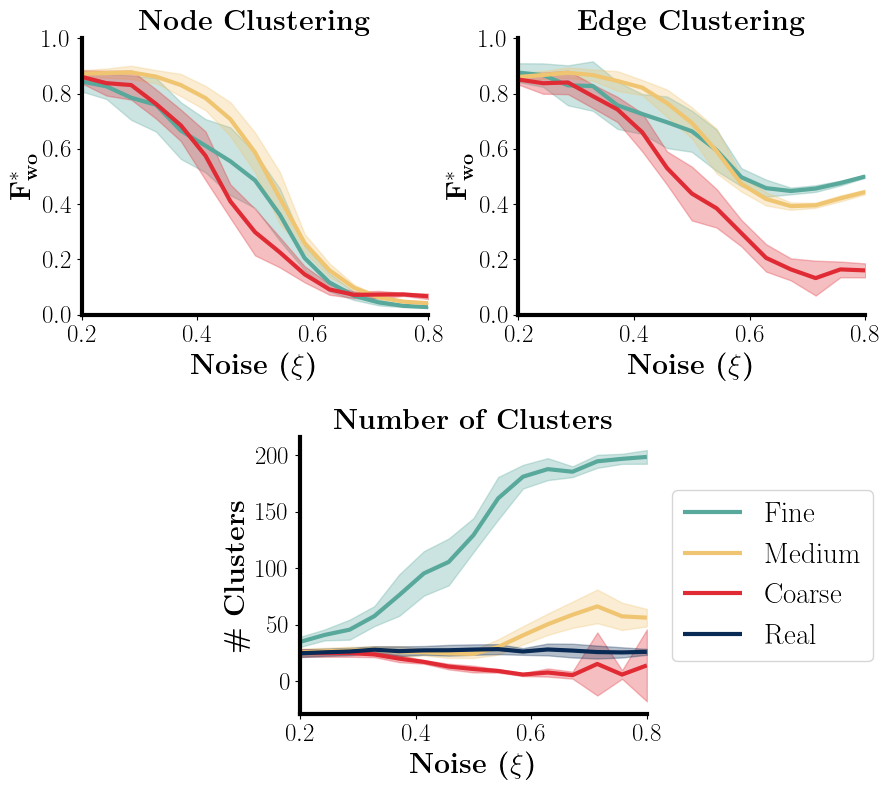

In [82]:
fig = plt.figure(figsize=(9,8))
gs = fig.add_gridspec(nrows=4, ncols=4)
ax1 = plt.subplot(gs[:2, :2])
ax2 = plt.subplot(gs[:2, 2:])
ax3 = plt.subplot(gs[2:4, 1:3])

axs = [ax1, ax2, ax3]

# plot results
XIS = np.linspace(0.2, 0.8, 15)
colors = [hex2rgb("#59a89c"), hex2rgb("#f0c571"), hex2rgb("#e02b35"), hex2rgb("#082a54")]

XIS = np.linspace(0.2, 0.8, 15)
similarity = np.load("similarity.npy")
ga_similarity = np.load("ga_similarity.npy")
num = np.load("num.npy")

similarity_mean = np.mean(similarity, axis=2)
similarity_std = np.std(similarity, axis=2)
ga_similarity_mean = np.mean(ga_similarity, axis=2)
ga_similarity_std = np.std(ga_similarity, axis=2)
num_mean = np.mean(num, axis=2)
num_std = np.std(num, axis=2)

for i, (m, s) in enumerate(
    [
        (similarity_mean, similarity_std),
        (ga_similarity_mean, ga_similarity_std),
        (num_mean, num_std)
    ]):
    axs[i].plot(XIS, m[0], color=colors[0],
            label = "Fine", lw = 3, dashes = [500,1])
    axs[i].plot(XIS, m[1], color=colors[1],
            label = "Medium", lw = 3, dashes = [500,1])
    axs[i].plot(XIS, m[2], color=colors[2],
            label = "Coarse", lw = 3, dashes = [500,1])
    axs[i].fill_between(XIS, m[0] - s[0],
        m[0] + s[0], color=colors[0], alpha=0.3)
    axs[i].fill_between(XIS, m[1] - s[1],
        m[1] + s[1], color=colors[1], alpha=0.3)
    axs[i].fill_between(XIS, m[2] - s[2],
        m[2] + s[2], color=colors[2], alpha=0.3)

axs[i].plot(XIS, num_mean[3], color=colors[3],
    label = "Real", lw = 3, dashes = [500,1])
axs[i].fill_between(XIS, num_mean[3] - num_std[3],
    num_mean[3] + num_std[3], color=colors[3], alpha=0.3)

axs[0].set_xlim([np.min(XIS), np.max(XIS)])
axs[1].set_xlim([np.min(XIS), np.max(XIS)])
axs[2].set_xlim([np.min(XIS), np.max(XIS)])

axs[0].set_ylim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.0])

axs[0].tick_params(labelsize=18)
axs[1].tick_params(labelsize=18)
axs[2].tick_params(labelsize=18)

axs[0].set_ylabel(r"\huge $\mathbf{F^*_{wo}}$")
axs[1].set_ylabel(r"\huge $\mathbf{F^*_{wo}}$")
axs[2].set_ylabel(r"\huge \bf \# Clusters")

axs[0].set_xlabel(r"\huge \bf Noise ($\mathbf{\xi}$)")
axs[1].set_xlabel(r"\huge \bf Noise ($\mathbf{\xi}$)")
axs[2].set_xlabel(r"\huge \bf Noise ($\mathbf{\xi}$)")

axs[0].set_title(r"\huge \bf Node Clustering")
axs[1].set_title(r"\huge \bf Edge Clustering")
axs[2].set_title(r"\huge \bf Number of Clusters")

axs[2].legend(loc='center left', bbox_to_anchor=(1.03, 0.5), fontsize=21)

for ax in axs:
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(3)

plt.tight_layout(w_pad=-1.3, h_pad=0.1)
plt.subplots_adjust(wspace=0.7, hspace=1.6)
#plt.show()
plt.savefig("fig3_alt.pdf")